<a href="https://colab.research.google.com/github/ujs/open_data/blob/master/DeepLearningArt_NeuralStyleTransfer.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Neural Style Transfer**

### **Introduction:**
Neural style transfer (NST) is a technique in deep learning that allows us to generate beautiful pieces of art by merging two images, namely: a 'content' image (C) and a 'style' image (S) to create a 'generated' image (G).
As the name suggests, the generated image G combines the content of image C with the style of image S.



![alt text](https://media-exp1.licdn.com/dms/image/C4E12AQEfjA-SVxYLVQ/article-cover_image-shrink_600_2000/0?e=1594252800&v=beta&t=c-Nk6o0GkraP7w44YfqE54_iHzX9wsvtSd758Bd1rAQ)


*Fig 1- A style transfer example* (Source: [Linkedin](https://www.linkedin.com/pulse/artificial-intelligence-applications-neural-style-transfer-mohan/))

NST uses a pretrained convolutional network- this concept of applying a neural network trained on a different task is called *transfer learning*.
In this project I will use some content and style images to generate art. I will run different iterations of this technique on the same images to visualise how the generated images change. In this project, I will use the VGG19 network by Gatys et al. This network is a variant(with three more convolutional layers) of the VGG16 architecture which is widely used for ImageNet.

### **NST Algorithm:**
The main idea behind NST is similar to all other deep learning algorithms: we define a loss function, and then we minimize the loss with respect to some parameters using some form of gradient descent. In NST, the loss function is defined as a combination of 2 loss functions: one is a function of the content image and generated image (the *content loss*), and the other is a function of style image and generated image (the *style loss*).

i.e **total loss = content loss + style loss**

The content loss is usually computed by calculating the L2 norm (magnitude of difference) between the activations of content image and activations of generated image when passed through a cetain deeper layer in the network. In simple words, we can think of this as the degree of difference between the content image and the generated image. We would like to minimize this difference.

For the style loss, we use a Gram matrix (matrix of dot products) of a layer's activations which is basically the inner product of the feature maps of a given layer (the inner product can be seen as map of correlations between different features within the layer- in case of an image we can consider different color channels as features). We compute the gram matrix for image S and gram matrix for image G and our goal is to minimize the difference (distance) between these matrices. 
Hence, the style loss tries to capture image texture by preserving similar channel correlations for various layers.

The main steps of the NST process are:

*   Initialize a random image as the generated image G - the parameters in this algorithm are the pixel values of the image G.
*   Set up a network that passes content image C, style image S and generated image G through pretrained VGG19 layer at the same time and computes layer activations.
*   After forward pass through the network, compute the loss function.
*   Use gradient descent to minimize the loss function with respect to parameters (pixel values of G) and obtain the final image G.







### **Implementation:**
I will use python libraries to implement NST: Keras, Tensorflow, numpy, scipy are the main libraries for deep learning and machine learning in python. First step is to import all necessary libraries & load, preprocess the images.

In [0]:
#Importing libraries
import os
import sys
import scipy.io
import scipy.misc
import matplotlib.pyplot as plt
from matplotlib.pyplot import imshow
from keras.preprocessing.image import load_img, img_to_array
from keras.applications import vgg19
from keras import backend as K
from PIL import Image
#from nst_utils import *
import numpy as np
import tensorflow as tf
import pprint
%matplotlib inline

Using TensorFlow backend.


In [0]:
#Load and preprocess images
def take_image_inputs(content_img_code, style_img_code, img_height = 400):
  content_image_path = '/content/' + content_img_code + '.jpg'
  style_image_path = '/content/' + style_img_code + '.jpg'
  width, height = load_img(content_image_path).size
  img_width = int(width * img_height / height)
  return content_image_path, style_image_path, img_width, img_height

def preprocess_image(image_path):
  img = load_img(image_path, target_size=(img_height, img_width))
  img = img_to_array(img)
  img = np.expand_dims(img, axis=0)
  img = vgg19.preprocess_input(img)
  return img

def deprocess_image(img):
  '''This function reverses some unnecessary transformations 
  done by vgg19.preprocess_input in previous function '''
  img[:, :, 0] += 103.939
  img[:, :, 1] += 116.779
  img[:, :, 2] += 123.68
  img = img[:, :, ::-1]   #converts 'BGR' to 'RGB'
  img = np.clip(img, 0, 255).astype('uint8')
  return img  

In [0]:
#Passing image C, S and G through VGG19
def load_model(content_image_path, style_image_path, img_width, img_height):
  content_image = K.constant(preprocess_image(content_image_path))
  style_image = K.constant(preprocess_image(style_image_path))
  generated_image = K.placeholder((1, img_height, img_width, 3))

  #Combine 3 images into a single batch and feed into VGG19

  input_tensor = K.concatenate([content_image,style_image,generated_image], axis=0)
  model = vgg19.VGG19(input_tensor=input_tensor, weights='imagenet',include_top=False)
  print('Model loaded.')
  return model

In [0]:
#Define content loss
def content_loss(base, generated):
  return K.sum(K.square(generated - base))

#Define style loss
def gram_matrix(img):
  features = K.batch_flatten(K.permute_dimensions(img, (2, 0, 1)))
  gram = K.dot(features, K.transpose(features))
  return gram

def style_loss(style, generated):
  S = gram_matrix(style)
  G = gram_matrix(generated)
  channels = 3
  size = img_height * img_width
  return K.sum(K.square(S - G)) / (4. * (channels ** 2) * (size ** 2))

# To smoothen the generated image and avoid over pixelated images, we apply variation loss
def total_variation_loss(img):
  a = K.square(img[:, :img_height - 1, :img_width - 1, :] - img[:, 1:, :img_width - 1, :])
  b = K.square(img[:, :img_height - 1, :img_width - 1, :] - img[:, :img_height - 1, 1:, :])
  return K.sum(K.pow(a + b, 1.25))

#Define total loss (combination of style, content loss, variation loss)
def total_loss(model):
  outputs_dict = dict([(layer.name, layer.output) for layer in model.layers])
  content_layer = 'block5_conv2'
  style_layers = ['block1_conv1','block2_conv1','block3_conv1','block4_conv1','block5_conv1']
  total_variation_weight = 1e-4
  style_weight = 1.
  content_weight = 0.025
  loss = K.variable(0.)
  layer_features = outputs_dict[content_layer]
  content_image_features = layer_features[0, :, :, :]
  generated_features = layer_features[2, :, :, :]
  loss = loss +  content_weight * content_loss(content_image_features,generated_features)
  for layer_name in style_layers:
    layer_features = outputs_dict[layer_name]
    style_features = layer_features[1, :, :, :]
    generated_features = layer_features[2, :, :, :]
    sl = style_loss(style_features, generated_features)
    loss = loss + (style_weight / len(style_layers)) * sl
  loss = loss + total_variation_weight * total_variation_loss(generated_image)
  return loss, generated_image

In [0]:
#Gradient descent to minimise loss

def grads_cals(loss, generated_image):
  grads = K.gradients(loss, generated_image)[0]
  fetch_loss_and_grads = K.function([generated_image], [loss, grads])
  return grads, fetch_loss_and_grads


class Evaluator(object):

  def __init__(self):
    self.loss_value = None
    self.grads_values = None

  def loss(self, x):
    assert self.loss_value is None
    x = x.reshape((1, img_height, img_width, 3))
    outs = fetch_loss_and_grads([x])
    loss_value = outs[0]
    grad_values = outs[1].flatten().astype('float64')
    self.loss_value = loss_value
    self.grad_values = grad_values
    return self.loss_value

  def grads(self, x):
    assert self.loss_value is not None
    grad_values = np.copy(self.grad_values)
    self.loss_value = None
    self.grad_values = None
    return grad_values




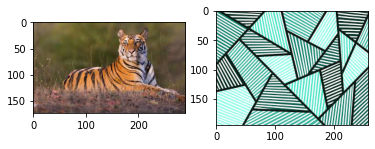

In [0]:
def original_images(content_image_path, style_image_path):
  fig, ax = plt.subplots(1,2)
  content_image = plt.imread(content_image_path)
  style_image = plt.imread(style_image_path)
  ax[0].imshow(content_image)
  ax[1].imshow(style_image)
  
original_images(content_image_path, style_image_path)






In [0]:
# Finally applying NST for few iterations and saving the results
from google.colab import files
from scipy.optimize import fmin_l_bfgs_b

def nst (content_img_code, style_img_code, img_height = 400, iterations = 2):

  iterations = 1
  content_image_path, style_image_path, img_width, img_height = take_image_inputs(content_img_code, style_img_code, img_height)
  model = load_model(content_image_path, style_image_path, img_width, img_height)
  loss = total_loss(model)
  evaluator = Evaluator()
  x = preprocess_image(content_image_path)
  x = x.flatten()
  for i in range(iterations):
    print('Start of iteration: ', i)
    x, min_val, info = fmin_l_bfgs_b(evaluator.loss, x, fprime=evaluator.grads, maxfun=10)
    img = x.copy().reshape((img_height, img_width, 3))
    img = deprocess_image(img)
  plt.imshow(img)


Model loaded.
Start of iteration:  0


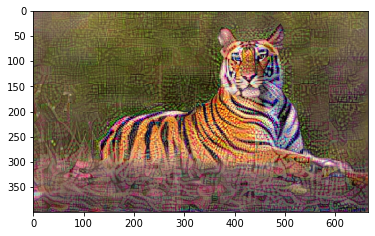

In [0]:
nst('1','a')